In [1]:
!pip install torchinfo

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 4.9 MB/s eta 0:00:00


# Working with your own dataset

In [3]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Tuple, Dict, List
import pathlib
from torchinfo import summary
from torchmetrics import Accuracy

In [4]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Get data

This data is a subset of the food101 dataset in torchvision datasets

In [6]:
# setup path to a data folder
data_path= Path('data/')
image_path= data_path /'pizza_steak_sushi'

if image_path.is_dir():
  print (f'{image_path} already exists, skipping download')
else:
  print (f'{image_path} does not exist, downloading one...')
  image_path.mkdir(parents= True, exist_ok= True)

data/pizza_steak_sushi does not exist, downloading one...


In [7]:
# downloadpizza, steak and sushi data
with open(data_path/ 'pizza_steak_sushi.zip', 'wb') as f:
  request= requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  f.write(request.content)

  # unzip it
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    zip_ref.extractall(image_path)

In [8]:
request

<Response [200]>

# Data Exploration

In [9]:
# Walkthrough the directory
def walkthrough_dir(dir_path):
  '''
  walks through a dir path
  returning its content'''
  for dirpath, dirname,filenames in os.walk(dir_path):
    print (f'there are {len(dirname)} directories and {len(filenames)} images in {dirpath}')


In [10]:
image_path

PosixPath('data/pizza_steak_sushi')

In [11]:
walkthrough_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/test
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/train
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [12]:
# setup training and test path
train_dir= image_path/'train'
test_dir= image_path/'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

* when creating an image classification problem, ensure that the image is stored in its classifications folder e.g
* dog image is stored in dog folder and cat image is stored in cat folder

In [13]:
list(image_path.glob(pattern= '*/*/*.jpg'))[: 10]

[PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg')]

## Visualizing our data
Writing some code that will
* Get all image paths
* Pick a random image path
* Get image class name
* open the image using PIL

In [14]:
# get all image path6
image_path_list= list(image_path.glob(pattern= '*/*/*.jpg'))

# pick a random image path
random.seed(42)
random_= random.choice(image_path_list)
print (random_)

# Get the image class
image_class= random_.parent.stem
print (image_class)

data/pizza_steak_sushi/test/sushi/3196729.jpg
sushi


Random image path: data/pizza_steak_sushi/test/sushi/3196729.jpg
image class: sushi
image height: 384
image width: 512


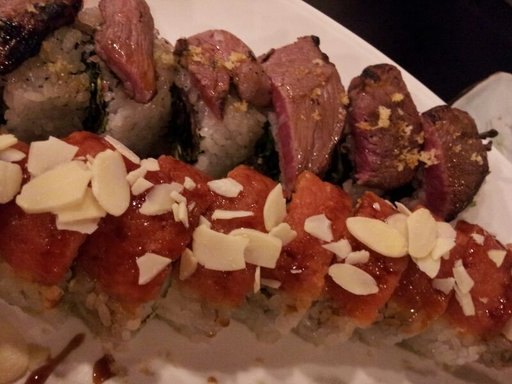

In [15]:
img= Image.open(random_)
print (f'Random image path: {random_}')
print (f'image class: {image_class}')
print (f'image height: {img.height}')
print (f'image width: {img.width}')
img

### Visualizing image with matplotlib

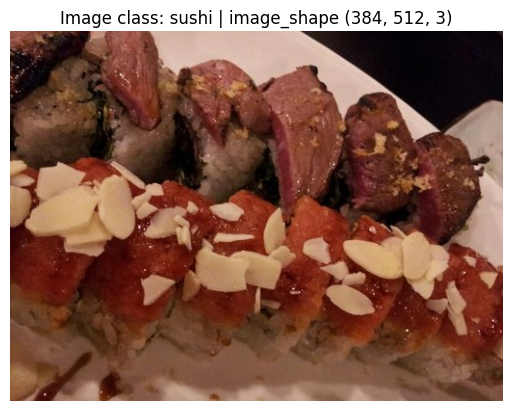

In [16]:
img_array= np.asarray(img)
#print(img_array.shape)
plt.imshow(img_array)
plt.title(f'Image class: {image_class} | image_shape {img_array.shape}')
plt.axis(False);

### Transforming data into tensors

*   Turn data into tensors
*   Turn tensors into a torch.utils.data.dataset
*   Turn data into batches.i.e dataloader



In [17]:
data_transform= transforms.Compose([
    # Resize our images to 64*64
    transforms.Resize(size=(64,64)),
    # Flip the images
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn an image into a torch tensor
    transforms.ToTensor()
])

In [18]:
data_1=data_transform(img)

In [19]:
data_1.shape, data_1.dtype

(torch.Size([3, 64, 64]), torch.float32)

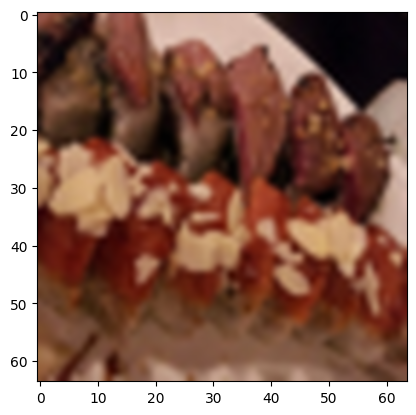

In [20]:
plt.imshow(data_1.permute(1,2,0), interpolation= 'spline36')

In [21]:
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg')]

In [22]:
def plot_transformed(image_paths, transform, n=3, seed=None):
  '''
  selects random images from data anf load/transform then
  plot the original vs the transformed version
  '''

  if seed:
    random.seed(seed)
  random_image_paths= random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax= plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image= transform(f)
      ax[1].imshow(transformed_image.permute(1,2,0))
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      # Super title
      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


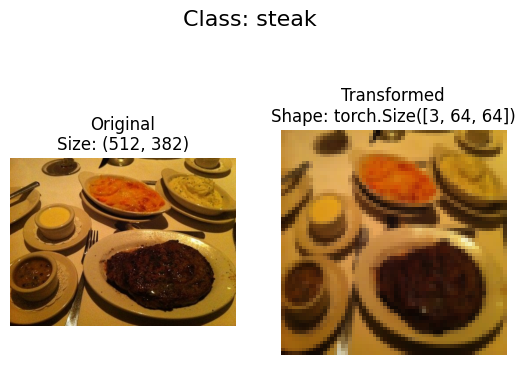

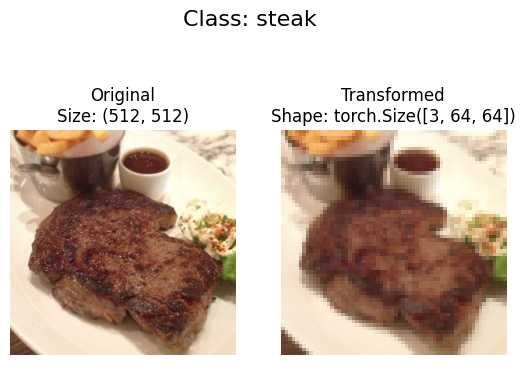

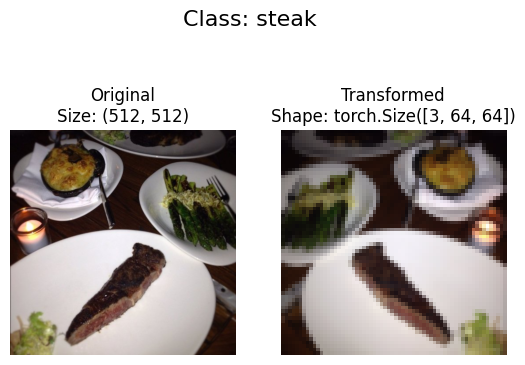

In [23]:
plot_transformed(image_paths= image_path_list,
                 transform= data_transform,
                 n=3,
                 #seed=42
                 )

## Loading data using torchvision dataset: Using `Imagefolder`

In [24]:
print (f'train data folder: {train_dir}')
print(f'\n Transform data with:\n {data_transform}')

train data folder: data/pizza_steak_sushi/train

 Transform data with:
 Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


In [25]:
# using imagefolder to create a dataset
from torchvision import datasets

train_data= datasets.ImageFolder(root= train_dir,
                                 transform= data_transform, # transform for the data
                                 target_transform= None)# transform for the target

In [26]:
test_data= datasets.ImageFolder(root= test_dir,
                                 transform= data_transform)

In [27]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [28]:
dir(test_data)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_transform_repr',
 '_is_protocol',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'find_classes',
 'imgs',
 'loader',
 'make_dataset',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']

In [29]:
test_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [30]:
class_names= test_data.classes
class_names

['pizza', 'steak', 'sushi']

In [31]:
len(test_data), len(train_data)

(75, 225)

In [32]:
train_data.samples

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1572608.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1633289.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1649276.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1654444.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1660415.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1899785.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1947572.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1968947.jpg',

In [33]:
train_data.root

PosixPath('data/pizza_steak_sushi/train')

In [34]:
img, label= train_data[0]

In [35]:
img.shape

torch.Size([3, 64, 64])

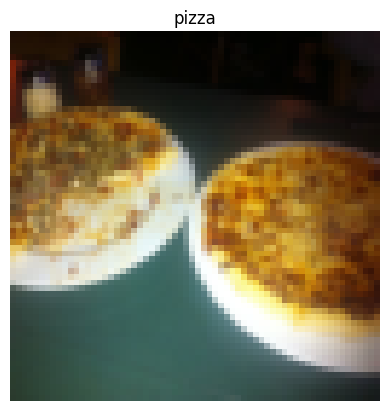

In [36]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

### Turn data into batches

In [37]:
os.cpu_count()

2

In [38]:

batch_size=1
train_dataloader= DataLoader(dataset= train_data,
                             batch_size=batch_size,
                             shuffle= True,
                             num_workers= 1
                             )

test_dataloader= DataLoader(dataset= test_data,
                            batch_size=batch_size,
                            shuffle= True,
                            num_workers= 1) # the more the better

In [39]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cd17f6f3c70>,
 <torch.utils.data.dataloader.DataLoader at 0x7cd17f6f28c0>)

In [40]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [41]:
img, label= next(iter(train_dataloader))

img.shape, label

(torch.Size([1, 3, 64, 64]), tensor([1]))

## Option 2: Loading image dataset without the `ImageFolder` library i.e loading the data with a custom `Dataset`
* To be able to load image form file
* To be able to get class names from dataset
* To be able to get classes as dictionary from dataset

In [42]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function that will get class names form a directory. i.e do what is above

In [43]:
# set up path directory
target_dir= train_dir
print (f'target_dir: {target_dir}')

# Get class names from target dir
class_names_found= sorted([entry.name for entry in os.scandir(target_dir)])
class_names_found

target_dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [44]:
# turning the code above to a function
def find_classes(directory: str)-> Tuple[list[str], Dict[str, int]]:
  '''
  Finds the class folder names in a target directory
  '''
  # Get the class names by scanning the target directory
  classes= sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
  # Raise an error if file name cannot be found
  if not classes:
    raise FileNotFoundError(f' Couldnt find any classes in {directory}...please check the file structure')

  # create a dict of index labels
  class_to_idx= {class_name:i for i, class_name in enumerate(classes)}
  return (classes, class_to_idx)

In [45]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom dataset to replicate `ImageFolder`


In [46]:
from torch.utils.data import Dataset
# Write a custom dataset class

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # Initialize our custom dataset
  def __init__(self, target_dir:str, transform=None):
    # create class attributes
    # get all the image paths
    self.paths=list(pathlib.Path(target_dir).glob('*/*.jpg'))
    # setup transform
    self.transform= transform
    # create classes and class_to_idx attribute
    self.classes, self.class_to_idx= find_classes(target_dir)

  # create a function to load images
  def load_image(self, index:int) ->Image.Image:
    image_path= self.paths[index]
    return Image.open(image_path)

  # overwrite __len__()
  def __len__(self) -> int:
    '''returns the total number of sample'''
    return len(self.paths)

  # overwrite __getitem__()
  def __getitem__(self, index:int) ->Tuple[torch.Tensor, int]:
    ''' Returns one sample of data and label (X,y)'''
    img= self.load_image(index)
    class_name= self.paths[index].parent.name
    class_idx= self.class_to_idx[class_name]
    # transform if neccessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx # untransformed image

In [47]:
# Create a transform using our custom data
train_transform= transforms.Compose([transforms.Resize(size= (64,64)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor()
                                    ])

test_transform= transforms.Compose([transforms.Resize(size= (64,64)),
                                    transforms.ToTensor()
                                    ])

In [48]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [49]:
train_data_custom= ImageFolderCustom(target_dir= train_dir,
                                     transform= train_transform,
                                     )
test_data_custom= ImageFolderCustom(target_dir= test_dir,
                                     transform= test_transform,
                                     )

In [50]:
train_data_custom.__len__(), test_data_custom.__len__()

(225, 75)

In [51]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

# Create a function to display random images

In [52]:
def display_images(dataset,
                   classes:List[str]= None,
                   n:int=10,
                   display_shape:bool= True,
                   seed:int= None):
  # Adjust display if n is too high
  if n>10:
    n=10
    display_shape= False
    print ('For display purpose, n should not be larger than 10. setting to 10 and removing shape display')

  # set the random seed
  if seed:
    random.seed(seed)

  # get random sample indexes
  random_samples_idx= random.sample(range(len(dataset)), k=n)

  # set up plot
  plt.figure(figsize=(16,8))

  # loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label= dataset[targ_sample][0], dataset[targ_sample][1]
    # adjust tensor dimensions for ploting
    targ_image_adjust= targ_image.permute(1,2,0)
    # plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = (f'Class: {classes[targ_label]}')
      if display_shape:
        title= title+f'\nShape: {targ_image_adjust.shape}'
    plt.title(title)

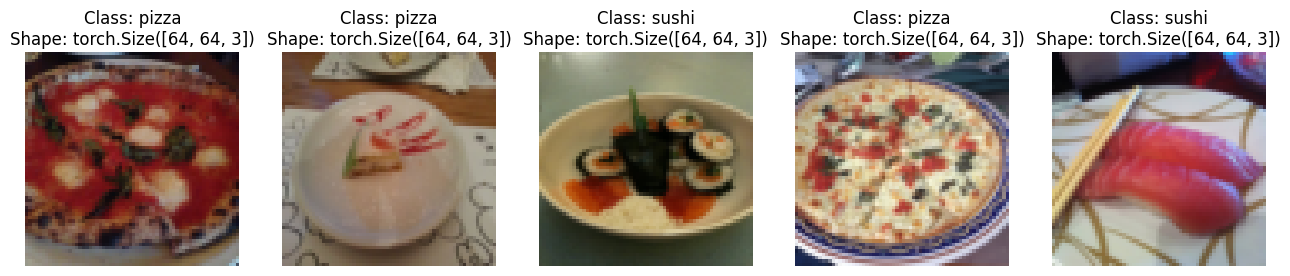

In [53]:
display_images(train_data, n=5,
               classes= class_names,seed= None)

For display purpose, n should not be larger than 10. setting to 10 and removing shape display


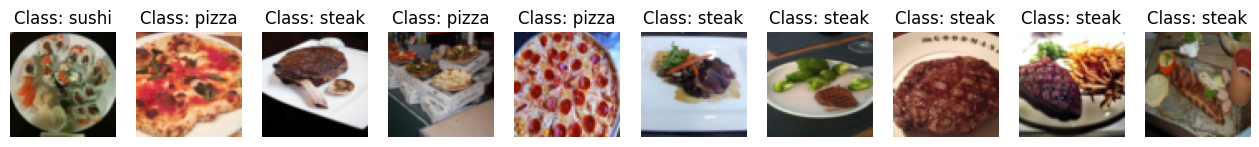

In [54]:
# display random images from the imagefolder custom dataset
display_images(dataset= train_data_custom, n=15,classes= class_names)

In [55]:
# Turn custom loaded data into dataloader
train_dataloader_custom= DataLoader(dataset= train_data_custom,
                                    batch_size=32,
                                    shuffle= True,
                                    num_workers=1)
test_dataloader_custom= DataLoader(dataset= test_data_custom,
                                   batch_size=32,
                                   num_workers= 1,
                                   shuffle=False)

In [56]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7cd17fa2a650>,
 <torch.utils.data.dataloader.DataLoader at 0x7cd17fa2a7d0>)

In [57]:
# get a image and label batch from the dataloader custom data
img_custom, label_custom= next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# Augmenting our data

In [58]:
train_transform = transforms.Compose([
    transforms.Resize(size=(225,225)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

test_transform= transforms.Compose([
    transforms.Resize(size=(225,225)),
    transforms.ToTensor()
])

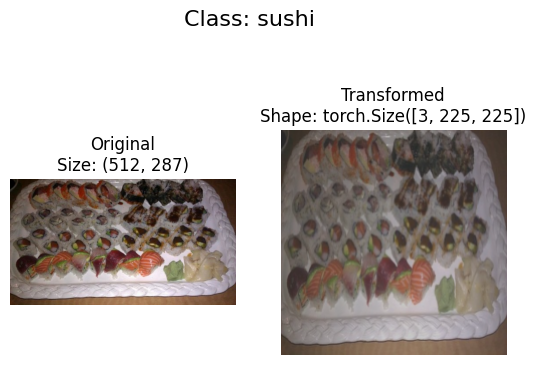

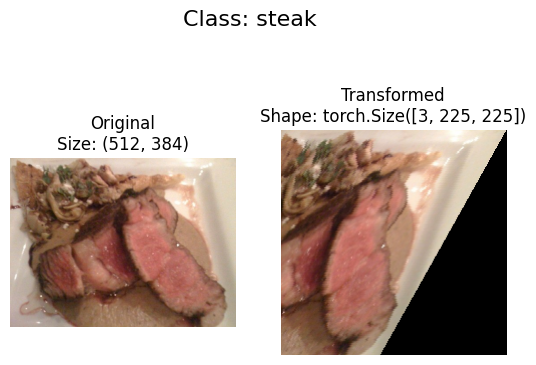

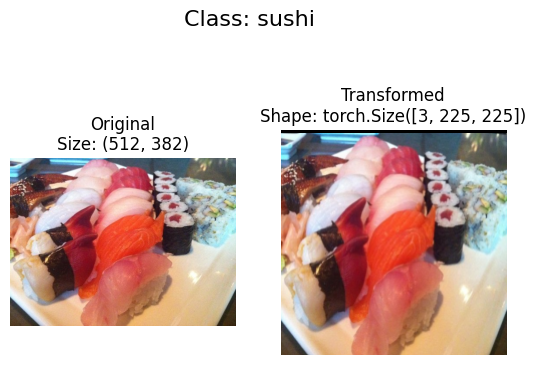

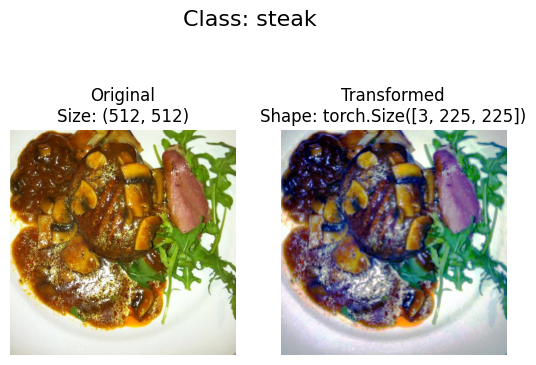

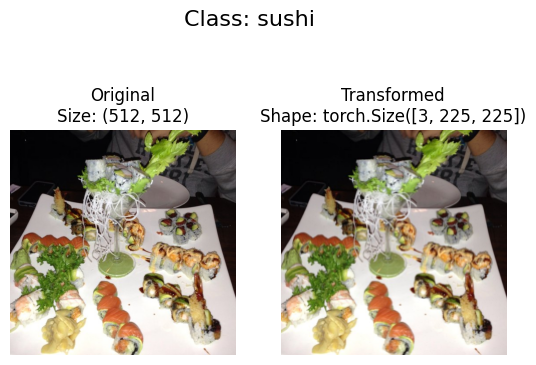

In [59]:
# get all image path
image_path_list= list(image_path.glob('*/*/*.jpg'))
#plot random transformed images
plot_transformed(image_paths= image_path_list, transform= train_transform, n=5,)

# Creating Baseline Model: TinyVGG and train the data without data Augmentation

In [60]:
# Create transform and load data
simple_transform= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

#load the data and transport it
train_data_simple = datasets.ImageFolder(root= train_dir,
                                         transform= simple_transform)
test_data_simple= datasets.ImageFolder(root= test_dir,
                                       transform= simple_transform)
# turn the datasets into batches
train_dataloader_simple= DataLoader(dataset= train_data_simple,
                                    batch_size= 32,
                                    num_workers=os.cpu_count(),
                                    shuffle= True)

test_dataloader_simple= DataLoader(dataset= test_data_simple,
                                    batch_size= 32,
                                    num_workers=os.cpu_count(),
                                    shuffle= True)

In [61]:
class TinyVGGModel(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.first_block= nn.Sequential(
        nn.Conv2d(in_channels= input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.second_block= nn.Sequential(
        nn.Conv2d(in_channels= hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features= output_shape)
    )

  def forward(self, x):
    x= self.first_block(x)
    #print (x.shape)
    x= self.second_block(x)
    #print (x.shape)
    x= self.classifier(x)
    #print (x.shape)
    return x




In [62]:
torch.manual_seed(42)
model= TinyVGGModel(input_shape= 3,
                    hidden_units=10,
                    output_shape=3).to(device)

In [63]:
image, label= next(iter(train_dataloader_simple))
image.shape

torch.Size([32, 3, 64, 64])

In [64]:
dummy_x= torch.randn(size= [1,3,64,64])
dummy_x.shape

torch.Size([1, 3, 64, 64])

In [65]:
model(dummy_x)

tensor([[ 0.0137, -0.0225, -0.0072]], grad_fn=<AddmmBackward0>)

### Using torchinfo to get information from our data

In [66]:
summary(model, input_size= [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModel                             [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [67]:
from tqdm.auto import tqdm

In [68]:
# Creating traininga and test function
def train_loop(model,optimizer, acc_function, loss_fn, dataloader, device):
  train_acc= 0
  train_loss=0
  model.train()
  for batches, (X, y) in enumerate(dataloader):
    X, y= X.to(device), y.to(device)
    y_pred= model(X)
    loss= loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += acc_function(y, y_pred.argmax(dim=1)).item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  #print (f'train loss {train_loss:.4f} | train accuracy {train_acc:.4f}')

  return train_loss, train_acc


In [69]:
def test_loop(dataloader, acc_function, model, loss_fn, device):
  test_acc= 0
  test_loss=0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y= X.to(device), y.to(device)
      test_pred= model(X)
      test_loss += loss_fn(test_pred, y).item()
      test_acc += acc_function(y, test_pred.argmax(dim=1)).item()

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    #print (f'test loss {test_loss:.4f} | test accuracy {test_acc:.4f}')

    return test_loss, test_acc


In [70]:
 # create a train function to combine train step and test step

def train_function(model, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn, epochs=5, device= device):
  # create empty result dictionary
  result= {'train_loss': [],
          'train_Acc': [],
          'test_loss': [],
          'test_Acc':[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc= train_loop(model=model,
                                      dataloader= train_dataloader,
                                      loss_fn= loss_fn,
                                      acc_function= accuracy_fn,
                                      device=device, optimizer=optimizer)
    test_loss, test_acc= test_loop(model=model,
                                   dataloader= test_dataloader,
                                   acc_function= accuracy_fn,
                                   loss_fn= loss_fn,
                                   device= device)

    # print out what is happening
    print (f'Epochs: {epoch} | train loss {train_loss:.4f} | Train acc: {train_acc:.4f} |test_loss {test_loss:.4f}| test acc {test_acc:.4f} ')

    # updata result dictionary
    result['train_loss'].append(train_loss)#.item())
    result['test_loss'].append(test_loss)#.item())
    result['train_Acc'].append(train_acc)#.item())
    result['test_Acc'].append(test_acc)#.item())

  return result

## Train and evaluate data using baseline model

In [71]:
acc_fn= Accuracy( task= 'multiclass', num_classes=3).to(device)
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

In [72]:
torch.manual_seed(42)
model_result= train_function(model= model,
                             loss_fn= loss_fn,
                             optimizer= optimizer,
                             device=device,
                             test_dataloader= test_dataloader_simple, train_dataloader= train_dataloader_simple,
                             epochs=5, accuracy_fn= acc_fn )

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0 | train loss 1.1035 | Train acc: 0.2500 |test_loss 1.1009| test acc 0.2604 
Epochs: 1 | train loss 1.0766 | Train acc: 0.4258 |test_loss 1.1075| test acc 0.3400 
Epochs: 2 | train loss 1.1290 | Train acc: 0.3047 |test_loss 1.0991| test acc 0.3598 
Epochs: 3 | train loss 1.0792 | Train acc: 0.4258 |test_loss 1.0912| test acc 0.3703 
Epochs: 4 | train loss 1.0951 | Train acc: 0.3164 |test_loss 1.0729| test acc 0.3911 


In [73]:
model_result

{'train_loss': [1.10354582965374,
  1.0766455456614494,
  1.1290420442819595,
  1.0792125016450882,
  1.0950651615858078],
 'train_Acc': [0.25, 0.42578125, 0.3046875, 0.42578125, 0.31640625],
 'test_loss': [1.1009183327356975,
  1.107516884803772,
  1.0990502834320068,
  1.091232458750407,
  1.0728912353515625],
 'test_Acc': [0.2604166666666667,
  0.3399621248245239,
  0.3598484893639882,
  0.3702651560306549,
  0.3910984893639882]}

## Plot the loss curve of the model

In [74]:
model_result.keys()

dict_keys(['train_loss', 'train_Acc', 'test_loss', 'test_Acc'])

In [75]:
def loss_curve_plot(results: Dict[str, List[float]]):
  '''plots training curves of result dictionary'''
  # get the loss values of the results dictionary (training and test)
  loss= results['train_loss']
  test_loss= results['test_loss']
  # get the accuracy of the result dictionary
  acc= results['train_Acc']
  test_acc= results['test_Acc']
  # get number of epochs
  epochs= range(len(results['train_loss']))
  # setup a plot
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label= 'train_loss')
  plt.plot(epochs, test_loss,label= 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  # second plot
  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label= 'train_accuracy')
  plt.plot(epochs, test_acc, label= 'test_Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

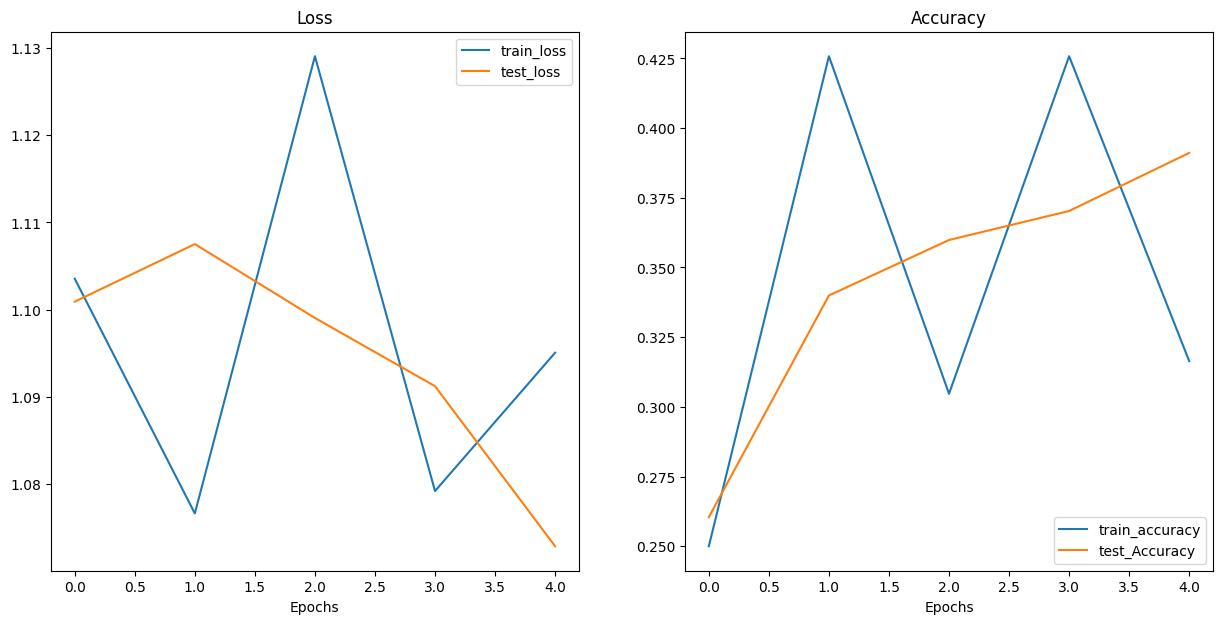

In [76]:
loss_curve_plot(model_result)

## Using data augmentation to prevent overfitting and improve model capability of learning

# TinyVGG With DataAugmentation

In [77]:
#create a transform with data augmentation
train_transform_trivial= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [78]:
# Create train and test dataset and dataloaders with data augmentation
train_trivial= datasets.ImageFolder(root= train_dir, transform= train_transform_trivial)
test_trivial= datasets.ImageFolder(root= test_dir, transform=test_transform_simple)

# Turn the datasets into dataloader
train_trivial_dataloader= DataLoader(dataset= train_trivial,
                                     batch_size= 32,
                                     shuffle= True,
                                     num_workers=2)

test_trivial_dataloader= DataLoader(dataset= test_trivial,
                                     batch_size= 32,
                                     shuffle= False,
                                     num_workers=2)

In [79]:
torch.manual_seed(42)
model_1= TinyVGGModel(input_shape=3,
                      hidden_units=10,
                      output_shape=3).to(device)


In [80]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_1.parameters(), lr=0.001)
acc_fn= Accuracy(task= 'multiclass', num_classes= 3)

In [81]:
torch.manual_seed(42)
model_1_result= train_function(model_1, train_dataloader= train_trivial_dataloader,
               test_dataloader= test_trivial_dataloader, optimizer=optimizer,
               loss_fn= loss_fn, device=device,accuracy_fn=acc_fn
               )

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0 | train loss 1.1049 | Train acc: 0.2500 |test_loss 1.1019| test acc 0.2604 
Epochs: 1 | train loss 1.0807 | Train acc: 0.4258 |test_loss 1.1261| test acc 0.2604 
Epochs: 2 | train loss 1.0712 | Train acc: 0.4258 |test_loss 1.1593| test acc 0.2604 
Epochs: 3 | train loss 1.1253 | Train acc: 0.3047 |test_loss 1.1581| test acc 0.2604 
Epochs: 4 | train loss 1.0865 | Train acc: 0.4258 |test_loss 1.1555| test acc 0.3333 


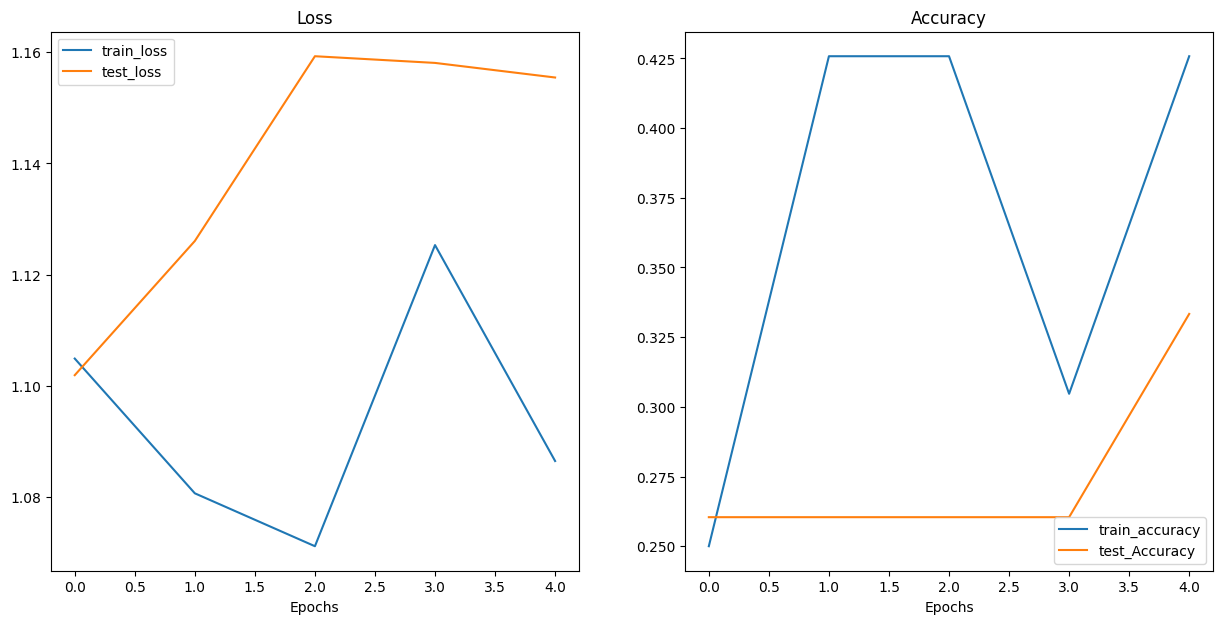

In [82]:
# plot the loss curve
loss_curve_plot(model_1_result)

### Compare our model results to each other

In [83]:
import pandas as pd
model_df= pd.DataFrame(model_result)
model_1_df= pd.DataFrame(model_1_result)

In [84]:
model_df

train_loss  train_Acc  test_loss  test_Acc
0    1.103546   0.250000   1.100918  0.260417
1    1.076646   0.425781   1.107517  0.339962
2    1.129042   0.304688   1.099050  0.359848
3    1.079213   0.425781   1.091232  0.370265
4    1.095065   0.316406   1.072891  0.391098

In [85]:
model_1_df

train_loss  train_Acc  test_loss  test_Acc
0    1.104914   0.250000   1.101928  0.260417
1    1.080687   0.425781   1.126056  0.260417
2    1.071174   0.425781   1.159278  0.260417
3    1.125320   0.304688   1.158074  0.260417
4    1.086493   0.425781   1.155451  0.333333

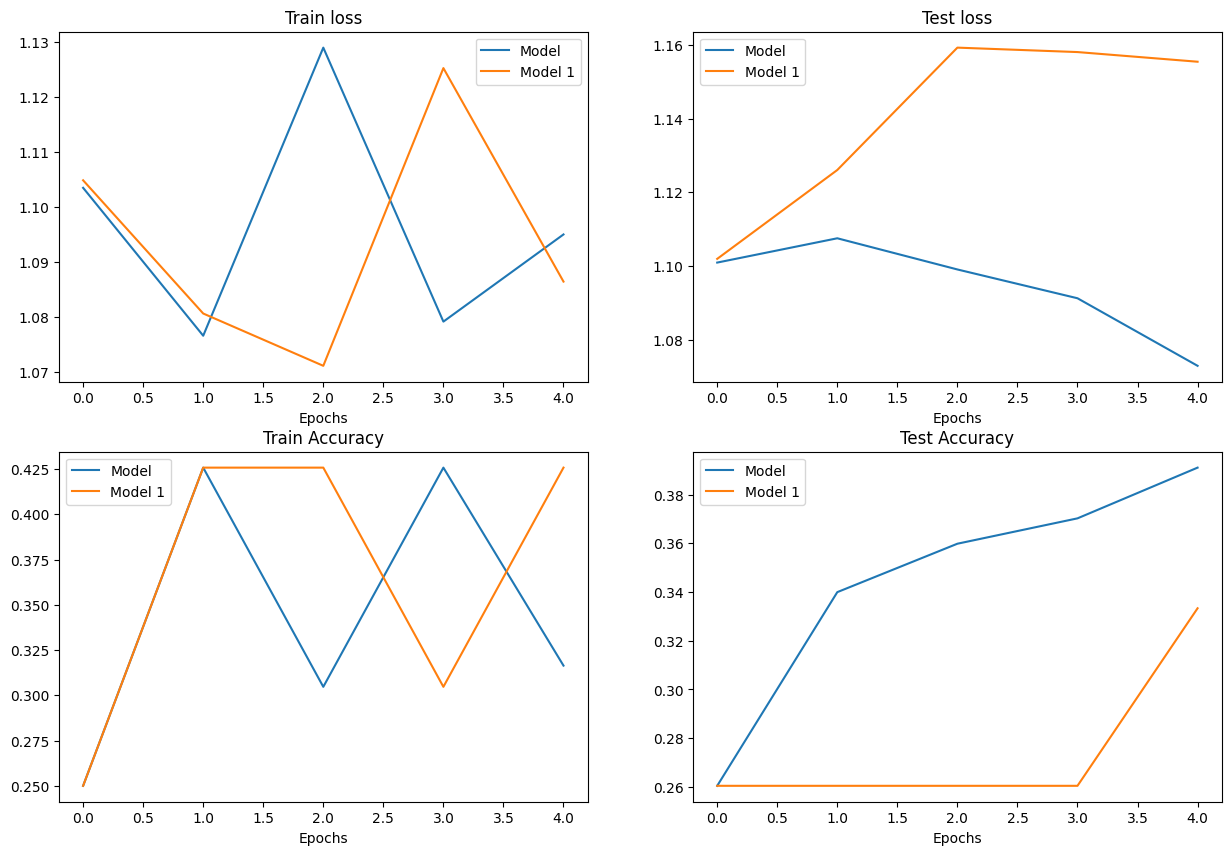

In [86]:
# Setup a plot
plt.figure(figsize=(15,10))
# get number of epochs
epochs= range(len(model_df))

# plot for the train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_df['train_loss'], label= 'Model')
plt.plot(epochs, model_1_df['train_loss'], label= 'Model 1')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()

# Second plot
plt.subplot(2,2,2)
plt.plot(epochs, model_df['test_loss'], label= 'Model')
plt.plot(epochs, model_1_df['test_loss'], label= 'Model 1')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

# third plot
plt.subplot(2,2,3)
plt.plot(epochs, model_df['train_Acc'], label= 'Model')
plt.plot(epochs, model_1_df['train_Acc'], label= 'Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

# fourth plot
plt.subplot(2,2,4)
plt.plot(epochs, model_df['test_Acc'], label= 'Model')
plt.plot(epochs, model_1_df['test_Acc'], label= 'Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend();

# Predicting on custom data

In [87]:
# Making a prediction on a custom image
# downloading an image
image_path= data_path/'04_pizza_dad.jpeg'
if not image_path.is_file():
  with open(image_path, 'wb') as f:
    request= requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
    f.write(request.content)
else:
  print ('already exist')

In [88]:
# we need to make sure the data is on the right device and it must be in the same shape as the data our model was trained on
image_path

PosixPath('data/04_pizza_dad.jpeg')

In [89]:
import torchvision

In [90]:
# loading in a custom image with pytorch
custom_image_new= torchvision.io.read_image(path='data/04_pizza_dad.jpeg' )
custom_image_new

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

In [91]:
# image have to be converted to a float because we are using float dtype earlier

In [92]:
custom_image_new.shape

torch.Size([3, 4032, 3024])

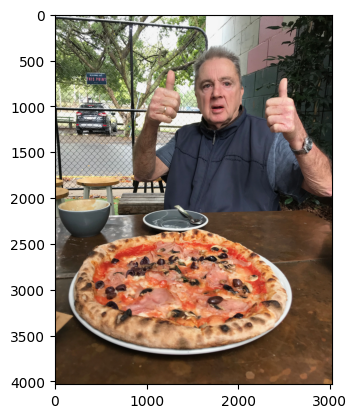

In [93]:
plt.imshow(custom_image_new.permute(1,2,0))

In [94]:
# convert the datatype to float32 and normalize to zero
custom_image_fl= custom_image_new.type(torch.float32) / 255.
custom_image_fl

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

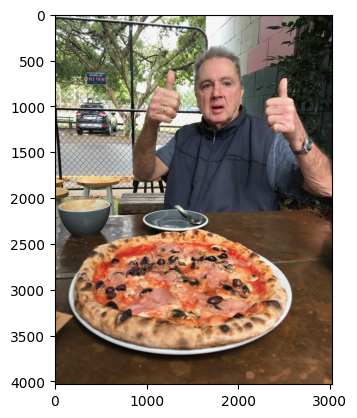

In [95]:
plt.imshow(custom_image_fl.permute(1,2,0))

In [96]:
from pandas.tseries.offsets import CustomBusinessDay
trans= transforms.Compose([
    transforms.Resize(size= (64,64))
])

custom_img_tr= trans(custom_image_fl)
custom_img_tr.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 64, 64])

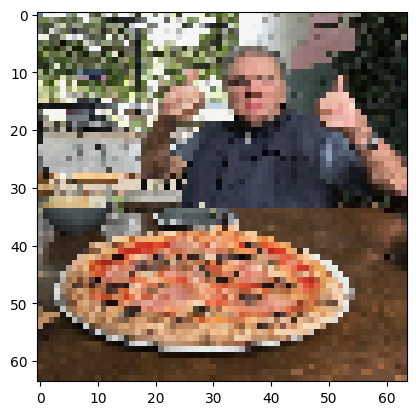

In [97]:
plt.imshow(custom_img_tr.permute(1,2,0))

In [98]:
# we have to add a batchsize to our image data
model_1.eval()
with torch.inference_mode():
  custom_img_pred= model_1(custom_img_tr.unsqueeze(dim=0).to(device))

In [99]:
custom_img_pred.argmax(dim=1)

tensor([0])

In [100]:
# convert logits to pred probs to pred labels
custom_img_pred_prob= torch.softmax(custom_img_pred, dim=1)
custom_img_pred_prob

tensor([[0.3635, 0.3591, 0.2774]])

In [101]:
custom_img_pred_label= custom_img_pred_prob.argmax(dim=1)
custom_img_pred_label

tensor([0])

In [102]:
class_names[custom_img_pred_label]

'pizza'

In [103]:
# functionising the code
def prediction(model:torch.nn.Module, filepath:str, device, class_names: list[str]):
  '''a function where we pass an image path and have the function predict what the model is'''
  data = torchvision.io.read_image(filepath).type(torch.float32) /255
  transform= transforms.Compose([
      transforms.Resize(size= (64,64))
  ])
  transform_data= transform(data)
  model.eval()
  with torch.inference_mode():
    y_logit= model(transform_data.unsqueeze(dim=0).to(device))
    img_prob= torch.softmax(y_logit, dim=1).argmax(dim=1)
    class_name= class_names[img_prob]
  fig= plt.imshow(transform_data.permute(1,2,0))
  plt.title(class_name)

  return fig

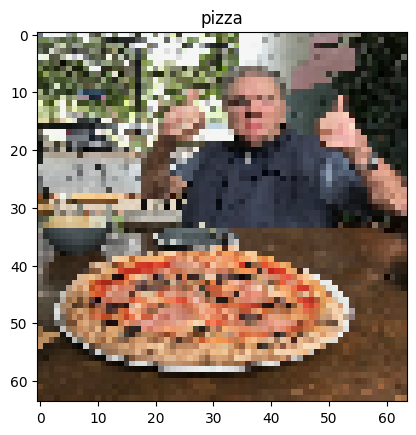

In [104]:
prediction(model= model_1,filepath= 'data/04_pizza_dad.jpeg', device=device, class_names= class_names )